# Creating a Transformer Encoder from Scratch with PyTorch
This notebook is a tutorial and implementation of the transformer architecture from the seminal paper Attention Is All You Need https://arxiv.org/abs/1706.03762. We're only going to build the *encoder block*, which correponds to the left side of the diagram.

To get the most out of this tutorial, it is recommended that readers have an understanding of rudimentary linear algebra and are familiar with deep learning with PyTorch, Long Short-Term Memory (LSTM) recurrent neural networks, autoencoders, and Natural Language Processing (NLP) concepts, such as tokenization and word embeddings.

## Introduction
<img src="https://i.imgur.com/Iv0MBNZ.png" 
     align="right" 
     width="350" />
     
Transformers have been instrumental in processing sequential data. Before their advent, Long Short-Term Memory (LSTM) recurrent neural networks were considered the standard method for such tasks. LSTMs however have some significant issues:
1. LSTMs tend to 'forget' information at the beginning of long sequences. Consequently, their performance worsens as the length of the sequence increases.
2. In LSTMs, each cell relies on the output of the preceding cell, necessitating a sequential completion of forward and backward passes. This will make the complexity of training an LSTM proportional to the length of the input, which is an issue for GPUs which are designed to optimize parallel computation.

Transformers fully address both of these issues by allowing for sequential data to be processed in parallel,as well as assigning 'attention' to important parts of the sequence. These two improvements are what have made transformers so successful. They are not limited to just NLP tasks too, they are usable in virtually all areas of machine learning, from reinforcement learning to computer vision to time series. This does not come without some caveats however. The primary caveats of transformers are that they have very expensive to train both in terms of VRAM and FLOPS, and they can be difficult to train from scratch, often due to the curse of dimensionality.

The transformer architecture from 'Attention Is All You Need' describes two main components, the *encoder* and the *decoder*. Their function is akin to the encoder-decoder pairs found in autoencoders; the encoder learns how to represent the input in a latent space, and the decoder translates this encoded data into the desired output form. Although this model was originally designed for sequence-to-sequence tasks like machine translation, both the encoder and decoder blocks have since been adapted for standalone use. There are three primary categories of transformer models:

- **Encoder only**: These models convert a sequence of inputs (like text, images, audio) into a rich numerical representation, making them well-suited for classification tasks. BERT and its variants are well-known examples of such models. This is what we're going to focus on.

- **Decoder only**: These models excel in tasks where it is unnecessary to embed the input, and the goal is merely to predict the next token. The GPT model family falls under this category.

- **Encoder-decoder**: These models are employed to model intricate mappings from one sequence to another. Machine translation, compression, and denoising are some examples of tasks where these models are used.

<img src="https://i.imgur.com/mZRlDQP.png" 
     align="left" 
     width="300" />
     
## The Encoder Only Architecture
     
The encoder on architecture has the following components, all of which we will explain in detail and implement in this tutorial:
1. **Input embedding**: An embedding layer, where a tokenized input sequence is represented as a sequence of embedding vectors.
2. **Positional encoding**: Provide the transformer with information about the position if each word in the sequence. Unlike in LSTMs, this information is not inherent in a transformer.
3. **Multi-head self-attention**: The key component of the transformer. Builds on the concept of attention in RNNs from Bahdanau, Cho and Bengio 2014 https://arxiv.org/abs/1409.0473.
4. **Residual connections and layer normalization**: Residual connections and layer normalization are applied multiple times in the transformer architecture. Residual connections came from He et al 2015 https://arxiv.org/abs/1512.03385 and layer normalization is considered to be an improvement on batch normalization, published in 2016 by Ba, Kiros and Hinton https://arxiv.org/abs/1607.06450.
5. **Feed forward**: A special version of a 2 layer feed-forward neural network is applied here; instead of processing the whole sequence of embeddings as a single vector, we process each embedding independently. This layer is often referred to as a *position-wise feed-forward layer*. In Attention Is All You Need, the GELU activation function is used (Hendrycks and Gimpel 2016 https://arxiv.org/abs/1606.08415).
6. **Linear and softmax**: After applying layer normalization and skip connections a second time, our output is passed through a classification head consisting of one dense layer with a softmax output.
7. **Output probabilities**: Our classification head outputs a probability distribution of our input belonging to each class.

---

# 0. Tokenization
Before we start working on our transformer architecture, we must first tokenize our text sequences.

Since tokenization is a core concept in NLP and we're not going to explain it in depth here. We're going to use subword tokenization, specifically WordPiece, which is used by the BERT and DistilBERT tokenizers.

Let's start by loading the tokenizer from the Hugging Face Transformers library:

BERT

In [2]:
import pandas as pd
from transformers import AutoTokenizer

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [4]:
text = 'Tokenizing text is a core concept in NLP.'

tokenized_text = {}
tokenized_text['Numerical Token'] = tokenizer(text)['input_ids']
tokenized_text['Token'] = tokenizer.convert_ids_to_tokens(tokenizer(text)['input_ids'])

print("Tokenizer has a vocabulary size of", tokenizer.vocab_size, "words.")
print("Tokenizer has a maximum sequence length of", tokenizer.model_max_length, "tokens.")
print("\nOur text to tokenize:", text, "\n")
#pd.DataFrame(tokenized_text).T.style.hide_columns()
#pd.DataFrame(tokenized_text).T.style.hide(axis='columns', subset=['column_name'])
pd.DataFrame(tokenized_text).T

Tokenizer has a vocabulary size of 30522 words.
Tokenizer has a maximum sequence length of 512 tokens.

Our text to tokenize: Tokenizing text is a core concept in NLP. 



0      1        2     3     4     5     6        7     8   \
Numerical Token    101  19204     6026  3793  2003  1037  4563     4145  1999   
Token            [CLS]  token  ##izing  text    is     a  core  concept    in   

                    9     10    11     12  
Numerical Token  17953  2361  1012    102  
Token               nl   ##p     .  [SEP]

#### Remarks:
- `[CLS]` Stands for *classifier* and indicates the start of a sequence.
- `[SEP]` Stands for *separate segment* and typically indicates the end of a sequence.
- We can see that 'Tokenizing' and 'NLP' have had their casing changed to lower, and both words have been split into 'token' + 'izing' and 'nl' + 'p'.
- The numerical indices each correspond to a word in the tokenizer's dictionary.

We're also going to create a sample text string that we'll pass through our network piece by piece, to ensure everything is working as intended:

与 encode 方法相比，encode_plus 提供了更多的功能和灵活性，尤其是在处理文本对（比如问答系统中的问题和答案）时。
encode_plus 可以根据设置对输入进行填充或截断，使得输入长度达到指定的最大长度。这对于批处理和模型输入一致性非常重要。
对于文本对的输入（如句子对），encode_plus 会生成 token_type_ids，标记出哪些 token 属于第一个句子，哪些 token 属于第二个句子。这对于 BERT 这种可以处理句子对的模型非常重要。

In [5]:
import torch

sample_text = "We're going to reduce the maximum sequence length to 100 tokens, \
so we'll use a longer string here for demonstration purposes. We're not going to \
reach the full 100 tokens, so we'll pad our sequence with 0s."

input_sequence = tokenizer.encode_plus(sample_text, return_tensors='pt', padding='max_length', truncation=True, max_length=100)['input_ids']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_sequence = input_sequence.to(device)

print(input_sequence)
print("\nShape of output:", input_sequence.shape)

tensor([[  101,  2057,  1005,  2128,  2183,  2000,  5547,  1996,  4555,  5537,
          3091,  2000,  2531, 19204,  2015,  1010,  2061,  2057,  1005,  2222,
          2224,  1037,  2936,  5164,  2182,  2005, 10467,  5682,  1012,  2057,
          1005,  2128,  2025,  2183,  2000,  3362,  1996,  2440,  2531, 19204,
          2015,  1010,  2061,  2057,  1005,  2222, 11687,  2256,  5537,  2007,
          1014,  2015,  1012,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])

Shape of output: torch.Size([1, 100])


# 1. Input Embedding

<img src="https://i.imgur.com/h9XnkhD.png" 
     align="right" 
     width="175" />

Our transformer architecture starts off with an embedding layer, where we represent each word as a vector in an embedding space. Like tokenization, word embeddings are a fundamental topic in NLP and explaining them would be beyond the scope of this notebook, however I have made this helpful notebook that serves to explain them:

https://www.kaggle.com/code/auxeno/word-embedding-visualization-with-glove-t-sne

### Implementing an Embedding Layer in PyTorch
The following is the code to implement an embedding layer in PyTorch, we also initialize our config dictionary which we will use throughout the program to define the parameters of our model.

In [6]:
# Making a lightweight config class that allows for struct like attribute accessing
class Config:
    def __init__(self, config_dict):
        self.__dict__.update(config_dict)

# Setting parameters for our model
config = {# We get the vocabulary size used by our tokenizer
          'vocab_size': tokenizer.vocab_size,
          
          # We will use 128 dimensional token embeddings initially
          'embedding_dimensions': 128,
        
          # We're only going to use a maximum of 100 tokens per input sequence
          'max_tokens': 100,

          # Number of attention heads to be used
          'num_attention_heads': 8,

          # Dropout on feed-forward network
          'hidden_dropout_prob': 0.3,

          # Number of neurons in the intermediate hidden layer (quadruple the number of emb dims)
          'intermediate_size': 128 * 4,

          # How many encoder blocks to use in our architecture
          'num_encoder_layers': 2,

          # Device
          'device': device
    
}
# Wrapping our config dict with the lightweight class
config = Config(config)

In [8]:
import torch.nn as nn

class TokenEmbedding(nn.Module):
    def __init__(self, config):
        super().__init__()
        # Create an embedding layer, with ~32,000 possible embeddings, each having 128 dimensions
        self.token_embedding = nn.Embedding(num_embeddings=config.vocab_size, embedding_dim=config.embedding_dimensions)

    def forward(self, tokenized_sentence):
        return self.token_embedding(tokenized_sentence)
    
token_embedding = TokenEmbedding(config).to(config.device)
embedding_output = token_embedding(input_sequence)
print("Shape of output:", embedding_output.size())

Shape of output: torch.Size([1, 100, 128])


#### Remarks:
- Our embedding layer ouputs a tensor of shape `[batch_size, seq_length, embedding_dims]`, which is what we expected. 

Next we will add the positional encodings to our embeddings:

---

# 2. Positional Encodings

<img src="https://i.imgur.com/jCnm8lE.png" 
     align="right" 
     width="175" />

Positional encodings are a vital part of the transformer architecture. Unlike Recurrent Neural Networks (RNNs), transformers do not operate sequentially, i.e., they do not move along a sequence piece-by-piece. Instead, transformers operate on the entire sequence all at once. Although this parallel processing significantly enhances the computational efficiency, it also imposes a challenge - transformers lack an inherent mechanism to account for the order of words in a sentence.

This is where positional encodings come in. The function of positional encodings is to provide the transformer model with information about the position of words within a sentence. They serve as a "fingerprint" that enables the transformer to identify the true position of each word.

### Calculating Positional Encodings

Positional encodings are calculated with the following formulae:

$$PE(position, i) = sin \left( \frac{position}{10000^{\frac{i}{d_{model}}}}\right) \textrm{for even i}$$
$$PE(position, i) = cos \left( \frac{position}{10000^{\frac{i-1}{d_{model}}}}\right) \textrm{for odd i}$$

Here, $i$ is the dimension and $d_{model}$ is the total number of dimensions in the token embedding. $position$ denotes the position of the word in the sentence.

The choice of sine and cosine functions is strategic, as these trigonometric functions produce values within the range of -1 to 1, which align well with the requirements of neural network inputs. Additionally their periodicity allows for easy extrapolation for sentences of varying lengths.

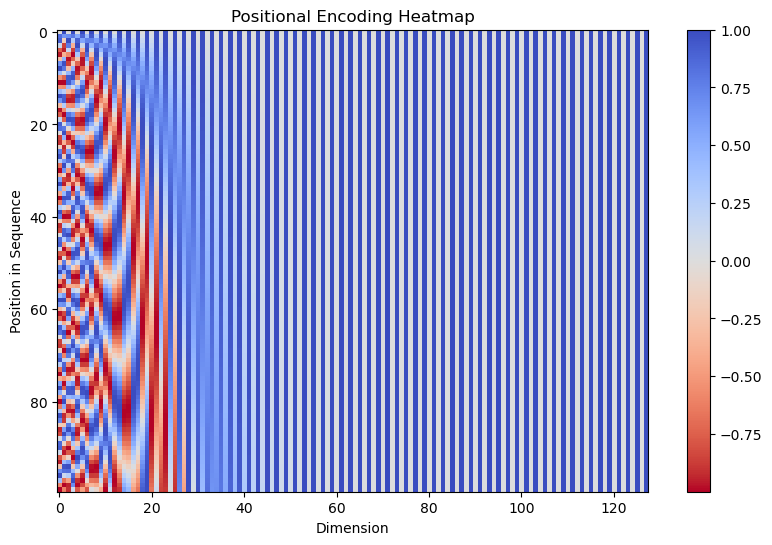

In [9]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"


# Number of possible positions (sequence length)
pos = config.max_tokens

# Number of latent space dimensions
d_model = config.embedding_dimensions

# Initialize matrix for positional encoding
pe = np.zeros((pos, d_model))

# Calculate positional encoding
for pos in range(pos):
    for i in range(0, d_model, 2):
        pe[pos, i] = np.sin(pos / (10000 ** ((2 * i) / d_model)))
        if i + 1 < d_model:
            pe[pos, i + 1] = np.cos(pos / (10000 ** ((2 * (i + 1)) / d_model)))

# Display as a heatmap
plt.figure(figsize=(10,6))
plt.imshow(pe, cmap='coolwarm_r')
plt.colorbar()
plt.xlabel('Dimension')
plt.ylabel('Position in Sequence')
plt.title('Positional Encoding Heatmap')

plt.show()

### Similarity of Positional Encodings
We can also observe that terms that are closer together, are more similar. This can be visualised by calculating the dot products between a positional vector and each other positional vector: 

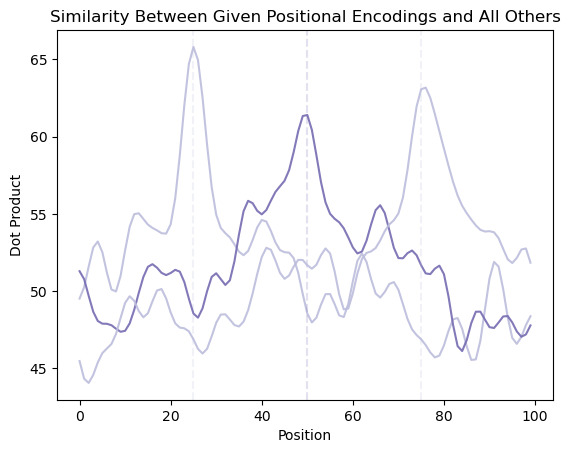

In [21]:
import matplotlib.pyplot as plt
import numpy as np

positions = [25, 50, 75]
dots = {25: [], 50: [], 75: []}

# Calculate values
for position in positions:
    for i in range(100):
        dots[position].append(np.dot(pe[position, :], pe[i, :]))

# Colors for plot
colors = plt.cm.tab20c([14, 12, 14])

# Plot the similarities
for position, color in zip(positions, colors):
    plt.plot(dots[position], color=color, alpha=0.9)
    plt.axvline(position, color=color, alpha=0.2, linestyle='--')

plt.title("Similarity Between Given Positional Encodings and All Others")
plt.xlabel("Position")
plt.ylabel("Dot Product")
plt.show()

### Applying Positional Encodings
The application of positional encodings is straightforward: they are simply added to each corresponding embedding vector in the sequence. For instance, the first embedding in the sequence has $PE(0)$ (the row at y=0 in the heatmap) added to it.

The addition of positional encodings equips the transformer model with a mechanism to understand the positions of each word in the sequence, allowing it to better interpret the sequence's contextual meaning.

### Implementing Positional Encodings in PyTorch

We can write our positional encodings using PyTorch tensors, then perform value inspection to ensure we calculated everything correctly:

In [10]:
class PositionalEncoding(nn.Module):
    def __init__(self, config):
        super().__init__()
        pe = torch.zeros(config.max_tokens, config.embedding_dimensions)
        position = torch.arange(0, config.max_tokens, dtype=torch.float).unsqueeze(1)
        div_term = 1 / (10000 ** (torch.arange(0, config.embedding_dimensions, 2).float() / config.embedding_dimensions))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.pe = pe.unsqueeze(0).transpose(0, 1)
        self.pe = self.pe.to(config.device)
        
    def forward(self, x):
        return x + self.pe[:, 0]

    
# Confirm this module is working as intended
positional_encoding = PositionalEncoding(config).to(config.device)
pos_enc_output = positional_encoding(embedding_output)
print("Shape of output:", pos_enc_output.size())

# View the difference between the two layers 
# These differences can be checked with our heatmap visualization
diff = pos_enc_output - embedding_output
print("\nTensor at position 0 first 20 values:")
print(diff[0,0][:20])
print("\nTensor at position 0 last 20 values:")
print(diff[0,0][-20:])

print("\nTensor at position 50 first 20 values:")
print(diff[0,50][:20])
print("\nTensor at position 50 last 20 values:")
print(diff[0,50][-20:])

Shape of output: torch.Size([1, 100, 128])

Tensor at position 0 first 20 values:
tensor([0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
        0., 1.], grad_fn=<SliceBackward0>)

Tensor at position 0 last 20 values:
tensor([0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000,
        1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 1.0000,
        0.0000, 1.0000], grad_fn=<SliceBackward0>)

Tensor at position 50 first 20 values:
tensor([-0.2624,  0.9650, -0.6320,  0.7750, -0.2030,  0.9792,  0.8690,  0.4948,
         0.1566, -0.9877, -0.7064,  0.7078,  0.7872, -0.6166, -0.5571,  0.8305,
        -0.1032, -0.9947,  0.9026,  0.4305], grad_fn=<SliceBackward0>)

Tensor at position 50 last 20 values:
tensor([0.0211, 0.9998, 0.0183, 0.9998, 0.0158, 0.9999, 0.0137, 0.9999, 0.0119,
        0.9999, 0.0103, 0.9999, 0.0089, 1.0000, 0.0077, 1.0000, 0.0067, 1.0000,
        0.0058, 1.0000], grad_fn=<SliceBackward0>)


#### Remarks:
- The shape of the outputs remains [1, 100, 128] which is what we expected.
- We can also see these values correspond to what we expected from the above positional encoding visualization.

---

# 3. Attention

<img src="https://i.imgur.com/hsH3PKz.png" 
     align="right" 
     width="175" />

Whilst not literally being 'all you need', multi-headed self-attention is probably the most revolutionary feature that came from transformers, so let's explore what it is.

### The Development and Role of Attention
The attention mechanism was introduced to address a limitation in sequence-to-sequence models, particularly when dealing with long sequences. Earlier models would encode the entire input sequence into a fixed-size vector, leading to a loss of information as the sequence length increased. 

Attention, however, allows the model to "focus" on various parts of the input sequence at different steps in the output sequence, dynamically re-weighting the input sequence to prioritize information most relevant to the current output.

Consider a machine translation task where the goal is to translate an English sentence, 'Bat in the cave', to French. Using a conventional word embedding model without attention, it's possible when our model reaches 'bat', it will elect to translate it as the more commonly used 'wooden object used to hit a ball'. We can use attention however to help our model make an association between 'bat' and 'cave' however. Here's how it works with a seq-to-seq LSTM model:

1. **Encoding the Source Sequence**: The source sequence, 'Bat in the cave', is processed by an encoder network such as an LSTM. This generates a series of hidden states, each of which captures the contextual information of the corresponding word in the sequence.
2. **Initializing the Decoder**: The decoder network, which also consists of an LSTM or similar recurrent unit, initializes its first input (usually a start-of-sequence token) and hidden state (often the final hidden state of the encoder).
3. **Decoding Step**: For each step of decoding, the current hidden state of the decoder is computed based on the input and previous hidden state.
4. **Calculating Alignment Scores**: The attention mechanism computes alignment scores between the current hidden state of the decoder and all hidden states of the encoder. These scores are essentially measures of relevance between the current output word being generated and each input word.
5. **Transforming Scores into Attention Weights**: The alignment scores are passed through a softmax function to convert them into attention weights. These weights sum to 1 and denote the importance of each word in the source sequence for predicting the current target word.
6. **Computing the Context Vector**: The context vector is a weighted sum of the encoder's hidden states, where the weights are given by the attention weights. This vector effectively concentrates the necessary information from the entire source sequence.
7. **Context Vector and Decoder Input**: The context vector is concatenated with the decoder's current input (an embedding of the target word from the previous step).
8. **Generating Decoder Output**: This concatenated vector is processed by the decoder network to generate the output (a probability distribution over target words) for the current time step.
9. **Updating the Decoder State**: The decoder's hidden state is updated based on the concatenated vector, and the current output word becomes the input for the next decoding step.
10. **Iterating Through Steps**: Steps 3-9 are iterated until an end-of-sentence token is produced or a predetermined maximum sequence length is reached.

To summarize this, in the vanilla attention mechanism with LSTMs, the attention operation is separate from the LSTM operations. The LSTM hidden states are used to calculate the context vector, which is then combined with the decoder's input at each step. This approach allows the model to dynamically focus on different parts of the input sequence when generating each word in the output sequence.

## Self-Attention
Now let's move onto the concept of self-attention, which is a very similar, but more generalized form of attention which is one of the key components in the Transformer model.

At a high level, both attention and self-attention mechanisms perform a similar function: they weight the importance of different inputs for each output. However, there are a few key differences in terms of design and function, which lead to unique strengths and use-cases for each.

### Sequence Context
In vanilla attention, the context is typically a sequence of encoder states and a single decoder state. The attention mechanism computes relevance scores (often called attention weights) between the decoder state and all the encoder states. These relevance scores tell us how much each part of the input sequence should contribute to the output at this particular time-step.

On the other hand, self-attention operates within a single sequence, without distinction between encoder and decoder states. For each position in the sequence, the self-attention mechanism computes relevance scores with all other positions in the same sequence. This allows each position to be updated based on all other positions, not just a single 'decoder' position.

### Directionality and Parallelization
Vanilla attention operates in a sequential manner, especially in conjunction with RNN-based models. Because of this sequential processing, parallel computation across time steps isn't possible, which can lead to slower training times for large models or long sequences.

In contrast, self-attention operates on all positions of the sequence simultaneously, making it highly parallelizable and more efficient on modern hardware accelerators. Each position in the sequence can be updated independently of the others, making self-attention a natural fit for 'transformer'-style models that avoid recurrent computations.

## Query Key and Value Vectors
Token embeddings by themselves represent an abstracted idea of tokens in a latent space. During the computation of attention weights, we first project our token embedding vectors into three new vectors, called *query, key and value*.

Each embedding vector will have its own associated query, key and value vectors associated with it. These vectors have both mathematical definitions as well as ways to think about them conceptually, but they are derived via three matrix transformations whose weights are learned during training. The purpose of the three vectors is ultimately to determine how much attention should be paid to each word in a sentence by each word.

### Query Vectors
The Query vector can be seen as a representation of the "question" being asked. When we want to pay attention to specific information in the context, we do so in relation to a particular query. For example, in the context of a sentence, if we're focusing on a particular word, the query vector would represent that word. 
Conceptually speaking, you could say that applying the query transformation would be like converting the embedding into a sort of request.

### Key Vectors
The Key vector can be considered as a representation of the "address" in the memory that matches a given query. In our sentence context, each word in the input sequence would have a corresponding key. These keys are compared with the query to determine how much attention should be paid to their corresponding values. A query to a very similar key would give a high relavance score, which is equivalent to saying we should pay more attention here. Queries to dissimilar keys would return a low relevance score.

### Value Vectors
The Value vector represents the actual "content" in the memory that we want to focus on or retrieve. For a simple embedding layer with no attention, this is essentially the embedding itself. In the sentence context, the value would be the information or representation we want to pull forward into our summary of the sentence when we're considering a particular word. Imagine we're querying 'bat' with 'cave', we'd then want to get the return the actual value of the 'flying nocturnal mammal'. Similarly, querying 'bat' with 'hit' we'd want to find the value vector of 'wooden object used to hit a ball'.

Now, let's talk about how these vectors interact to calculate the attention scores:

1. **Query-Key Interaction**: For each query, we calculate the dot product with every key. This provides a relevance score for each query-key pair. These scores represent how well each key (and its corresponding value) matches the query.

2. **Softmax Normalization**: The relevance scores are then passed through a softmax function. This ensures that the scores are normalized and sum up to 1, turning them into attention weights. Each weight indicates the importance of the corresponding key-value pair for the given query.

3. **Weighted Sum of Values**: The attention weights are used to take a weighted sum of the value vectors. This means values corresponding to higher-weighted keys (i.e., those that matched the query better) will contribute more to the final output.

4. **Output**: The result of this weighted sum is the output for each query, which is a context-sensitive representation of the original token embeddings. Each output is a mixture of the value vectors, with the weights determined by the compatibility between the query and each key.

This process is applied to all queries in parallel, resulting in a new set of vectors that convey the same information as the original embeddings but are weighted to emphasize the elements that are most relevant in each context. This is the essence of the self-attention mechanism.

## Visualizing Self-Attention
We're going to use a nifty visualization library call BertViz, which allows us to visualize various aspects of transformer models. We'll do so using a pretrained BERT model.

The two sentences we'll visualize:
- Bat in the cave
- Bat hit the baseball

Using the conventional word vector approach, the word 'bat' needs to contain information for both the flying mammal and the wooden stick at the same time. Using attention, we're able to produce unique vector embeddings for each sentence.

In [11]:
!pip install bertviz

In [12]:
from bertviz.transformers_neuron_view import BertModel
from bertviz.neuron_view import show

model = BertModel.from_pretrained(model_ckpt)

*Note that to fully visualize the output below, you should click the + symbol on the left side, then mouseover 'bat' on the left.*

In [13]:
text = "bat in the cave"
show(model, "bert", tokenizer, text, display_mode="light", layer=0, head=8)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
text = "bat hit the baseball"
show(model, "bert", tokenizer, text, display_mode="light", layer=0, head=8)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Insights:
- We can mouseover 'bat' on both visualizations to see that, 'bat' pays the most attention to 'cave' and 'baseball'.
- This attention mechanism is what allows our model to determine the meaning of 'bat' in both sentences.

## Multi-Head Self-Attention
Multi-head self-attention simply allows our model to use several of these self-attention heads at once. This allows the attention-heads to divide labor and learn to pay attention to different aspects of the sentence. This division of labor permits for a richer understanding of context in the sentence than using just a single head would. In the BERT model we just used, 12 self-attention heads are used. In the original 'Attention Is All You Need' paper, 8 are used.

### Implementing Self-Attention in PyTorch
Below is the code to implement self-attention in PyTorch. There are three clearly defined parts:
1. Scaled dot product attention: A helper function that scales the value by the dot product of the query and key using Torch matrix operations.
2. Attention head: A single attention head class.
3. Multi-head attention: A class that holds several attention heads.

In [15]:
import torch.nn.functional as F

def scaled_dot_product_attention(query, key, value):
    dim_k = query.size(-1)
    scores = torch.bmm(query, key.transpose(1, 2)) / np.sqrt(dim_k) 
    weights = F.softmax(scores, dim=-1)
    return torch.bmm(weights, value)
    
class AttentionHead(nn.Module):
    def __init__(self, embed_dim, head_dim):
        super().__init__()
        self.q = nn.Linear(embed_dim, head_dim)
        self.k = nn.Linear(embed_dim, head_dim)
        self.v = nn.Linear(embed_dim, head_dim)
        
    def forward(self, hidden_state):
        attn_outputs = scaled_dot_product_attention(self.q(hidden_state), 
                                                    self.k(hidden_state), 
                                                    self.v(hidden_state)) 
        return attn_outputs

class MultiHeadAttention(nn.Module): 
    def __init__(self, config):
        super().__init__()
        embed_dim = config.embedding_dimensions
        num_heads = config.num_attention_heads
        head_dim = embed_dim // num_heads
        self.heads = nn.ModuleList(
            [AttentionHead(embed_dim, head_dim) for _ in range(num_heads)]
        )
        self.output_linear = nn.Linear(embed_dim, embed_dim)
        
    def forward(self, hidden_state):
        x = torch.cat([h(hidden_state) for h in self.heads], dim=-1) 
        x = self.output_linear(x)
        return x
    
multihead_attn = MultiHeadAttention(config).to(config.device)
atn_output = multihead_attn(pos_enc_output)
print("Shape of output:", atn_output.size())
print("Number of heads:", len(MultiHeadAttention(config).heads))
multihead_attn.heads[:2]

Shape of output: torch.Size([1, 100, 128])
Number of heads: 8


ModuleList(
  (0-1): 2 x AttentionHead(
    (q): Linear(in_features=128, out_features=16, bias=True)
    (k): Linear(in_features=128, out_features=16, bias=True)
    (v): Linear(in_features=128, out_features=16, bias=True)
  )
)

#### Remarks:
- The shape of our output is correct, and we can see 8 heads have been created, each with 16 output features such that the concatenation of all sums to 128.

---

# 4. Residual Connections and Layer Normalization

The next step is to apply residual connections and layer normalization to our outputs. Let's look at both components.

<img src="https://i.imgur.com/Uipv4De.png" 
     align="right" 
     width="175" />

## Residual Connections
Residual connections, also known as skip or shortcut connections, were a significant development in deep learning, introduced by He et al. in 2015. Residual connections are a simple yet powerful concept; they allow gradients to flow directly through a few layers by having the original input added to the output of a block of layers.

### Why Use Residual Connections?
The motivation behind residual connections is the problem of vanishing gradients in deep neural networks. As the network gets deeper, gradients calculated during backpropagation become increasingly small. This means the weights and biases of earlier layers are updated very slowly, making the network hard to train.

Residual connections alleviate this problem by providing a "shortcut" for the gradients to flow through. They make it possible to train very deep networks without the risk of vanishing gradients.

## Layer Normalization
Layer Normalization is a type of normalization technique, similar to Batch Normalization but with different properties. It was introduced by Ba, Kiros and Geoffrey Hinton in 2016.

The core idea of Layer Normalization is to normalize the values of each feature vector in a batch independently, making the average of their means and variances zero and one, respectively. The primary advantage of Layer Normalization is that it works independently of batch size. This is an important feature for Transformer models, which tend to use smaller batch sizes due to memory constraints.

### Residual Connections and Layer Normalization in Transformers
Both residual connections and layer normalization play a crucial role in the architecture of transformer models.

Each sub-layer in the Transformer (self-attention, point-wise feed-forward) has a residual connection around it followed by layer normalization.

The output of each sub-layer is simply `LayerNorm(x + Sublayer(x))`, where Sublayer(x) is the function implemented by the sub-layer itself.

This means that the output of the sub-layer (like self-attention) is added to the original input before being normalized. This residual connection, therefore, allows the model to retain some of the original information, even as it passes through multiple layers.

We will fully implement this later when we build our Transformer module. For now, we'll just make a simple PyTorch implementation:

In [16]:
# First, we get our positional encoder output
x = pos_enc_output

# Instantiate the layer normalization 
layer_norm = nn.LayerNorm(config.embedding_dimensions).to(config.device)

# Our output is then defined as the normalized output of the attention block 
# plus the ouput of the positional encoder (skip connection)
add_norm_output = layer_norm(x + multihead_attn(x))

print("Shape of output:", add_norm_output.size())

Shape of output: torch.Size([1, 100, 128])


# 5. The Feed-Forward Network

<img src="https://i.imgur.com/FxIFK65.png" 
     align="right" 
     width="175" />
     
The next component we encounter is the *Position-Wise* Feed-Forward Network (FFN). The FFN consists of two fully connected layers that transform the output from the multi-head attention block.

### Purpose of the Feed-Forward Network
You may be wondering how the FFN slots in to the transformer architecture as it's not inherently obvious.

The multi-head attention block serves a role similar to discerning context or relations in a sentence. For instance, in the sentence, "The cat chases the mouse," the word "chases" has a different implication based on whether it's related to "cat" or "mouse". This block figures out such relations between words, effectively capturing the dependencies between them. It's as if it's creating a 'map' of the sentence, indicating how each word relates to every other.

Now, after this attention mechanism has built these relations, we have more context-rich representations of our words (tokens). But these representations are influenced heavily by the interactions with other words.

This is where the Feed-Forward Network FFN comes in. It's like a small neural network for each token. It takes the output of the attention mechanism (the context-enriched word representation) and applies further transformations to it. In a way, this is where the model gets to think about each word representation on its own. While the multi-head attention block gives the word its 'relational' meaning (how it relates to other words), the FFN is responsible for generating an intrinsic meaning (understanding the word in itself in context).


So, the purpose of the FFN is to process the context-sensitive representations further, enabling the model to recognize more complex patterns or features that couldn't be captured by just looking at the relationships between words.

This is still somewhat abstract, so let's give an example:

### Understanding the Purpose of Feed-Forward Networks Through An Example
Let's consider the sentence: "Don't listen to that, it's a red herring."

In this context, the self-attention mechanism within the transformer model allows different tokens to interact with each other. For instance, it allows the model to understand the association between 'red' and 'herring'. The self-attention block can potentially pick up that 'red herring' could mean two things: a literal 'red-colored fish' or a metaphorical 'misleading piece of information'.

The feed-forward network (FFN) comes into play after these relationships have been established. Even though the self-attention mechanism has linked 'red' with 'herring', it might not fully capture the abstract usage of 'red herring' in our sentence. Here, the FFN shines.

In the subsequent processing, the FFN takes in the output of the self-attention block -- 'red' and 'herring' as a combined, contextual representation. The role of the FFN is to then further transform this combined representation, helping the model to understand whether 'red herring' is likely being used idiomatically or literally. The FFN does so by applying a series of transformations, powered by its learnable parameters, that can capture such complex, high-level features in the data.

In essence, while the self-attention mechanism helps the model to attend to the correct associations, the FFN gives the model the ability to interpret these associations in a meaningful and nuanced way. This division of labor is one of the cornerstones of the Transformer architecture's success.

### Structure of the Feed-Forward Network
The Feed-Forward Network in the Transformer consists of two fully connected layers, with a non-linear activation function in between. The activation function used in Attention is All You Need and in most transformer models is GELU (Gaussian Error Linear Units).

An interesting aspect of the FFN in the Transformer is that it has an 'intermediate' size, which is larger than the input and output size. This design choice allows the model to create a larger representation space in the middle of the FFN, providing more capacity to learn complex patterns.

### Implementing the Feed-Forward Network in PyTorch
The implementation of the feed-forward network is straightforward, however, it's not quite a run-of-the-mill dense network. Try to spot why before we talk about it in the next section:

In [17]:
class FeedForward(nn.Module): 
    def __init__(self, config):
        super().__init__()
        self.linear_1 = nn.Linear(config.embedding_dimensions, config.intermediate_size)
        self.linear_2 = nn.Linear(config.intermediate_size, config.embedding_dimensions)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        
    def forward(self, x):
        x = self.linear_1(x) 
        x = self.gelu(x)
        x = self.linear_2(x) 
        x = self.dropout(x) 
        return x

### What's Unusual?
Let's follow the shape of our output as it passes through the network.

- The shape of the output after the self-attention block is `[batch_size, seq_length, embedding_dims]`
- This input is passed directly into the feed-forward network.
- Where's the `flatten()` operation?

In many other network architectures, we would first flatten the input to this network, giving us a shape of `[batch_size, seq_length * embedding_dims]`. This would effectively merge all the tokens and their embeddings into one large vector, and the information about the individual tokens (their 'positions' in the sequence) would be lost.

However, in the Transformer architecture, we want to retain this positional information. So instead of flattening the output, we process each token independently. This means we apply the same operations to each token in isolation.

We can think of it as though we have a small network with `embedding_dims` input neurons, and we pass each token (each one being an embedding_dims-dimensional vector) through this small network one by one.

Because each token is processed independently, the network is referred to as a *position-wise* feed-forward network. The term position-wise highlights the fact that we maintain the individual identity (or "position") of each token throughout this part of the processing.

It's important to note that although each token is processed independently, the weights in the feed-forward network are shared across all tokens. This ensures that the network is learning to recognize patterns that are useful across the entire sequence, rather than overfitting to specific tokens.

Now, let's pass our input tensor through this layer to make sure it's working as expected:

In [18]:
feed_forward = FeedForward(config).to(config.device)
ffn_output = feed_forward(add_norm_output)
print("Shape of output:", ffn_output.size())

Shape of output: torch.Size([1, 100, 128])


### Second Add and Norm
Following the architecture, we then apply residual connections and layer normalization again:

In [19]:
# First, we get our first add norm output 
x = add_norm_output

# Instantiate the layer normalization 
layer_norm = nn.LayerNorm(config.embedding_dimensions).to(config.device)

# This output is then defined as the normalized output of the FFN
# plus the output from the first add norm (skip connection)
add_norm_output2 = layer_norm(x + feed_forward(x))

print("Shape of output:", add_norm_output2.size())

Shape of output: torch.Size([1, 100, 128])


#### Remarks:
That's it! This output represents the output of the encoder block. All we need to do now is assemble everything and attach a classifier head.

# 6. Assembling a Complete Encoder Block

<img src="https://i.imgur.com/gYci9Lu.png" 
     align="right" 
     width="200" />

Now that we have implemented each piece of the encoder block, we can start assembling them together to form the encoder part of the Transformer architecture. To refresh, each encoder block is composed of the following components:

1. **Multi-head self-attention**: Allows each input to interact with every other input to figure out how they should be weighted or 'attended to'.
2. **Residual connections and layer normalization**: These techniques help to stabilize the learning process and mitigate the problem of vanishing/exploding gradients, which can occur in deep networks.
3. **Feed forward network**: A small, fully connected neural network that applies further transformations to the output of the self-attention mechanism. It refines the word representations by processing them individually.

### Implementing an Encoder Block in PyTorch
In Attention Is All You Need, the layer normalization configuration used is *post layer normalization*, whereby we place layer normalization in between the skip connections. This arrangement is tricky to train from scratch as the gradients can easily diverge. Instead we will use a slightly different variant called *pre layer normalization*, which is the most common variant found in transformer literature (Xiong et al. 2020 https://arxiv.org/abs/2002.04745).

<img src="https://i.imgur.com/lj5pme1.png" 
     align="center" 
     width="600" />

We're going to slightly diverge from Attention Is All You Need to utilize pre-LN.

In [20]:
class PostLNEncoder(nn.Module):
    "The original architecture used in Attention Is All You Need"
    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadAttention(config)
        self.layer_norm1 = nn.LayerNorm(config.embedding_dimensions)
        self.layer_norm2 = nn.LayerNorm(config.embedding_dimensions)
        self.feed_forward = FeedForward(config)
        
    def forward(self, x):
        # Layer normalization + skip connections over the self-attention block
        x = self.layer_norm1(x + self.attention(x))
        # Layer norm + skip connections over the FFN
        x = self.layer_norm2(x + self.feed_forward(x))
        return x
        
class Encoder(nn.Module):
    "The improved pre-LN architecture"
    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadAttention(config)
        self.layer_norm1 = nn.LayerNorm(config.embedding_dimensions)
        self.layer_norm2 = nn.LayerNorm(config.embedding_dimensions)
        self.feed_forward = FeedForward(config)
        
    def forward(self, x):
        # First perform layer normalization
        hidden_state = self.layer_norm1(x)
        # Then apply attention + skip connection
        x = x + self.attention(hidden_state)
        
        # Apply layer normalization before inputting to the FFN
        hidden_state = self.layer_norm2(x)
        # Apply FNN + skip connection
        x = x + self.feed_forward(hidden_state)
        return x    

    
# Verify this all works with the ouput of the positional embeddings
# Initialize an encoder block
encoder = Encoder(config).to(config.device)

# Pass the output from the positional encoder to the encoder block
encoder_output = encoder(pos_enc_output)

print("Shape of output:", encoder_output.size())

Shape of output: torch.Size([1, 100, 128])


# 7. Classifier Head
Since our transformer is a classifier, we finish off with a classifier head.

Our classifier head first flattens the output of the encoder block, then passes it through two dense layers with ReLU activation in the middle. Since we're going to use this transformer for binary classification, we then pass our final output through a sigmoid activation function.

In [21]:
class ClassifierHead(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(config.max_tokens * config.embedding_dimensions, 2 * config.embedding_dimensions)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(2 * config.embedding_dimensions, 1)
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.linear1(x))
        x = self.linear2(x)
        return torch.sigmoid(x) # Sigmoid activation for binary classification
    
# Initialize a classifier head
classifier = ClassifierHead(config).to(config.device)

# Pass the output from the positional encoder to the encoder block
pred = classifier(encoder_output)

print("Shape of output:", pred.size())
print("Prediction:", pred.item())

Shape of output: torch.Size([1, 1])
Prediction: 0.452179878950119


# 8. Assembling the Full Transformer

<img src="https://i.imgur.com/iuyrnqm.png" 
     align="right" 
     width="240" />

Finally, with all the individual components of our transformer in place, it's time to assemble them. We have crafted each building block: the input embeddings, positional encodings, self-attention mechanisms, the feed-forward network, and the classification head. 

Our embeddings + positional encodings are funnelled into the stack of transformer encoder blocks. Each encoder block applies the self-attention mechanism, enabling the model to weigh the importance of each input in relation to others. A feed-forward neural network then processes the attention outputs independently.

The output of one encoder block serves as the input to the next, creating a chain of processing units. This design choice was inspired by the ability to learn more complex patterns and dependencies between inputs as information flows from one block to the next. The residual connections and layer normalization steps in each block help combat the vanishing gradients problem, making it feasible to stack several encoder blocks together.

In Attention Is All You Need, the authors used a stack of 6 encoder blocks. This is by no means a magic number and, depending on the complexity of your task and the amount of data we have, we may find that a different number works better. A good starting point could be to use a smaller number of blocks (say, 2 or 3) and see how our model performs. If it seems to be underfitting the data, we could consider adding more blocks.

Once the input sequence has passed through all the encoder blocks, it's finally time for the classification head. This layer is designed to take the rich, context-aware representations produced by the transformer and distill them into final output probabilities for our classes.

Without further ado, let's assemble our transformer:

In [22]:
class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embedding = TokenEmbedding(config)
        self.positional_encoding = PositionalEncoding(config)
        self.encoders = nn.ModuleList([Encoder(config) for _ in range(config.num_encoder_layers)])
        self.classifier_head = ClassifierHead(config)
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        for encoder in self.encoders:
            x = encoder(x)
        return self.classifier_head(x)
    
# Instantiate a full model
model = Transformer(config).to(config.device)

# Make a prediction from the input sequence described earlier
pred = model(input_sequence)
print("Prediction:", pred.item())

Prediction: 0.5860140323638916


#### Remarks:
Our output represents the probability of the input text sequence belonging to class 1. 

We've successfully pieced together a Transformer model from scratch! The next logical step is to train it and observe its performance.

# 9. Training the Transformer
Now that we have our transformer ready, we need to train it on some real data. For this, we'll use a well-known dataset named 'Natural Language Processing with Disaster Tweets'.

The Disaster Tweets dataset is a compilation of 10,000 tweets that have been hand-classified. The tweets have been categorized into two classes: 'disaster' and 'non-disaster'. Our task is to train our Transformer to differentiate between the two based on the content of the tweet. This dataset is perfect for our purpose as it focuses solely on text data, and offers us a binary classification task to test our model.

### Loading the Data
First, we load our data. The dataset is already well organized and can be readily loaded into a Pandas DataFrame. 

For our task, we're only interested in two fields: the 'text' and 'target'. The 'text' field contains the content of the tweet, which we'll use as our input, and the 'target' field contains the label (0 or 1), which will serve as our ground truth during training.

In [23]:
#train_path, test_path = '../input/nlp-getting-started/train.csv', '../input/nlp-getting-started/test.csv'
train_path, test_path = './dataset/disaster_tweets/train.csv', './dataset/disaster_tweets/test.csv'
df = pd.read_csv(train_path, index_col=0, usecols=['id', 'text', 'target'])

df.head()

text  target
id                                                           
1   Our Deeds are the Reason of this #earthquake M...       1
4              Forest fire near La Ronge Sask. Canada       1
5   All residents asked to 'shelter in place' are ...       1
6   13,000 people receive #wildfires evacuation or...       1
7   Just got sent this photo from Ruby #Alaska as ...       1

### Splitting the Data: Training and Validation
To accurately gauge the performance of our model, we reserve a subset of our training data for validation. Here we will use an 80:20 training validation split.

In [24]:
from sklearn.model_selection import train_test_split

# Splitting the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

### Initializing the Tokenizer
To process our text data, we initialize a preconfigured WordPiece tokenizer. This tokenizer converts our text data into a numerical format that can be interpreted by our model.

In [26]:
model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

text = train_df.iloc[42].text

tokenized_text = {}
tokenized_text['Numerical Token'] = tokenizer(text)['input_ids']
tokenized_text['Token'] = tokenizer.convert_ids_to_tokens(tokenizer(text)['input_ids'])

print("Tokenizer has a vocabulary size of", tokenizer.vocab_size, "words.")
print("Tokenizer has a maximum sequence length of", tokenizer.model_max_length, "tokens.\n")
print("Sample tweet:", text, "\n")
# pd.DataFrame(tokenized_text).T.style.hide_columns()
pd.DataFrame(tokenized_text).T

Tokenizer has a vocabulary size of 30522 words.
Tokenizer has a maximum sequence length of 512 tokens.

Sample tweet: USATODAY: On today's #frontpage: #Bioterror lab faced secret sanctions. #RickPerry doesn't make the cut for FoxNewÛ_ http://t.co/5uKOHk7SoB 



e:\Programs\Anaconda\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


0     1     2      3     4     5      6     7     8   \
Numerical Token    101  3915  3406  10259  1024  2006   2651  1005  1055   
Token            [CLS]   usa  ##to  ##day     :    on  today     '     s   

                   9   ...    43    44    45    46     47    48    49    50  \
Numerical Token  1001  ...  2522  1013  1019  6968  11631  2243  2581  6499   
Token               #  ...    co     /     5  ##uk   ##oh   ##k   ##7  ##so   

                   51     52  
Numerical Token  2497    102  
Token             ##b  [SEP]  

[2 rows x 53 columns]

### Tokenization: Converting Text to Numeric Sequences
Here we proceed to apply our tokenizer to the text data present in both the training and validation datasets. This process transforms each text string into a corresponding sequence of numeric tokens. To ensure uniformity, each sequence is set to have a maximum length of 100 tokens. Any sequences shorter than this length are backward padded with zeros.

In [27]:
# We limit the maximum length to 100 per tweet
max_length = config.max_tokens

def tokenize_text(row, max_length):
    text = row['text']
    tokenized = tokenizer.encode_plus(text, padding='max_length', truncation=True, max_length=max_length)
    return tokenized['input_ids']

train_df['tokenized'] = train_df.apply(lambda row: tokenize_text(row, max_length), axis=1)
val_df['tokenized'] = val_df.apply(lambda row: tokenize_text(row, max_length), axis=1)


train_df.head()

text  target  \
id                                                                
7128  Courageous and honest analysis of need to use ...       1   
4688  @ZachZaidman @670TheScore wld b a shame if tha...       0   
6984  Tell @BarackObama to rescind medals of 'honor'...       1   
4103  Worried about how the CA drought might affect ...       1   
6706  @YoungHeroesID Lava Blast &amp; Power Red #Pan...       0   

                                              tokenized  
id                                                       
7128  [101, 26103, 1998, 7481, 4106, 1997, 2342, 200...  
4688  [101, 1030, 12397, 25290, 21804, 1030, 25535, ...  
6984  [101, 2425, 1030, 13857, 16429, 8067, 2000, 24...  
4103  [101, 5191, 2055, 2129, 1996, 6187, 14734, 245...  
6706  [101, 1030, 2402, 5886, 22504, 3593, 13697, 84...

### Preparing the Dataloaders
Next we leverage PyTorch's DataLoader utility. DataLoaders serve as efficient data pipelines that handle batching and shuffling of data, saving a significant amount of manual work.

In [29]:
from torch.utils.data import Dataset, DataLoader

X_train = train_df['tokenized']
y_train = train_df['target']

X_val = val_df['tokenized']
y_val = val_df['target']

class TextDataset(Dataset):
    def __init__(self, x_dataframe, y_dataframe):
        self.x_dataframe = x_dataframe
        self.y_dataframe = y_dataframe

    def __len__(self):
        return len(self.x_dataframe)

    def __getitem__(self, idx):
        x = self.x_dataframe.iloc[idx]  # Get the 'tokenized' data
        y = self.y_dataframe.iloc[idx]  # Get the 'target' data
        return torch.LongTensor(x), torch.tensor(y, dtype=torch.float32)

# Create both datasets
train_dataset = TextDataset(X_train, y_train)
val_dataset = TextDataset(X_val, y_val)

# Create the DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # Shuffle for random sampling without replacement
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

### The Training Loop
At this stage, we're ready to train our model. First, we define our loss function and the optimizer. After moving our model to a GPU (if one is available), we commence the training over 8 epochs.

For monitoring purposes, we log our training and validation metrics every 20 batches. This data will allow us to visualize our model's performance dynamics over time.

In [30]:
# Instantiate a transformer model
model = Transformer(config).to(config.device)

# Define loss function and optimizer
loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Move model to GPU if available
model = model.to(config.device)

# Number of training epochs
n_epochs = 8

# Metrics dictionary for plotting later
metrics = {
    'train_loss': [],
    'train_accuracy': [],
    'val_loss': [],
    'val_accuracy': [],
}

# Training loop
for epoch in range(n_epochs):
    for i, (inputs, targets) in enumerate(train_dataloader):
        
        # Move inputs and targets to device
        inputs = inputs.to(config.device)
        targets = targets.to(config.device)
        
        # Set model to training mode
        model.train()
        
        # Clear the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss
        train_loss = loss_function(outputs.squeeze(), targets)
        
        # Backward pass and optimize
        train_loss.backward()
        optimizer.step()
        
        # Calculate accuracy
        train_predictions = (outputs.squeeze().detach().cpu() > 0.5)
        train_accuracy = (train_predictions == targets.cpu()).type(torch.float).mean().item()

        # Validation loop
        if i % 20 == 0:
            model.eval()
            with torch.no_grad():
                val_losses = []
                val_accuracies = []

                for val_inputs, val_targets in val_dataloader:
                    val_inputs = val_inputs.to(config.device)
                    val_targets = val_targets.to(config.device)

                    val_outputs = model(val_inputs)
                    val_loss = loss_function(val_outputs.squeeze(), val_targets)
                    val_losses.append(val_loss.item())

                    val_predictions = (val_outputs.squeeze().detach().cpu() > 0.5)
                    val_accuracy = (val_predictions == val_targets.cpu()).type(torch.float).mean().item()
                    val_accuracies.append(val_accuracy)
            
            # Get the mean loss and accuracy over the validation set
            val_loss = np.mean(val_losses)
            val_accuracy = np.mean(val_accuracies)

            # Print metrics here during training
            # print(f"Epoch {epoch+1}/{n_epochs} Step {i} \tTrain Loss: {train_loss.item():.2f} \tTrain Accuracy: {train_accuracy:.3f}\n\t\t\tVal Loss: {val_loss:.2f}   \tVal Accuracy: {val_accuracy:.3f}")

            # Store metrics
            metrics['train_loss'].append(train_loss.item())
            metrics['train_accuracy'].append(train_accuracy)
            metrics['val_loss'].append(val_loss)
            metrics['val_accuracy'].append(val_accuracy)

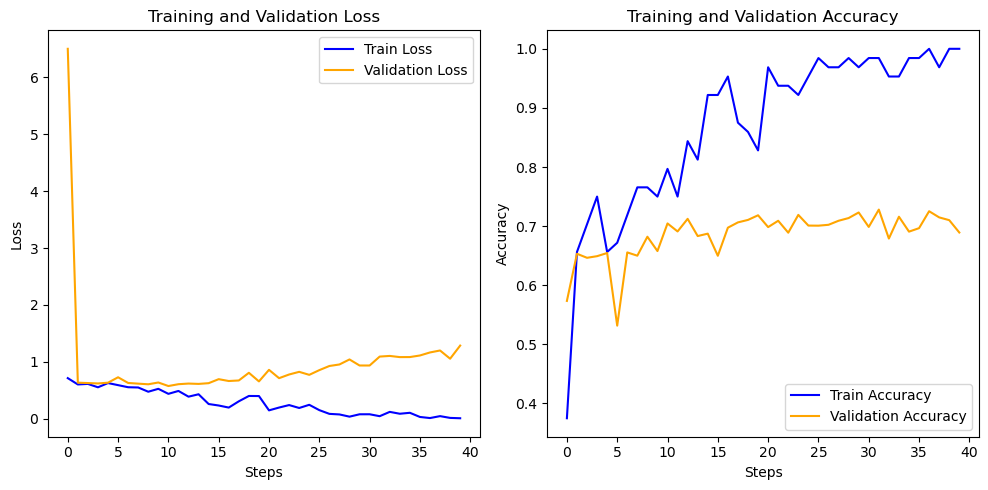

In [42]:
# Set up the figure and axes
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot the loss
ax[0].plot(metrics['train_loss'], color='blue', label='Train Loss')
ax[0].plot(metrics['val_loss'], color='orange', label='Validation Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].set_xlabel('Steps')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plot the accuracy
ax[1].plot(metrics['train_accuracy'], color='blue', label='Train Accuracy')
ax[1].plot(metrics['val_accuracy'], color='orange', label='Validation Accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].set_xlabel('Steps')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# Display the figure
plt.tight_layout()
plt.show()

# Remarks
- We've succesfully overfit our training data, indicating that our transformer implementation was a success!
- Training transformers is a whole topic on its own, and improving the performance of our model is outside the scope of this notebook.

# Wrapping Up
Well done on reaching the end of this notebook! Finishing this tutorial, you have achieved a significant milestone in understanding and implementing one of the most revolutionary architectures in the field of deep learning - the Transformer. 

We have learned about its intricacies, understood its components and developed an encoder-only Transformer from scratch using PyTorch. This lays a strong foundation for you to understand and use more complex Transformer models like BERT and GPT in your future work.

I hope you found this educational notebook helpful, I put a lot of time into it. All feedback is welcome.